# Model Performance Analysis

In [1]:
from configparser import ConfigParser
import yaml
import os
import pandas as pd
import matplotlib.pyplot as plt

from current_research_feature_effects.plotting.plots import boxplot_model_results

In [2]:
EXPERIMENT_NAME = "main_study"

os.chdir("..")

config = ConfigParser()
config.read(f"./experiments/{EXPERIMENT_NAME}/{EXPERIMENT_NAME}.ini")

['./experiments/main_study/main_study.ini']

In [3]:
model_results_storage = config.get("storage", "model_results")

with open(config.get("simulation_params", "datasets_yaml"), "r") as file:
    datasets_config = yaml.safe_load(file)
datasets = list(datasets_config.keys())
df = pd.DataFrame()
dfs = []
for dataset in datasets:
    df_temp = pd.read_sql_table(
        "model_results", f"sqlite:///experiments/{EXPERIMENT_NAME}/{dataset}{model_results_storage}"
    )
    df_temp["dataset"] = dataset
    df_temp = df_temp.sort_values(by=["dataset", "model", "n_train", "simulation"])
    dfs.append(df_temp)
    df = pd.concat([df, df_temp]).drop(columns=["index"])

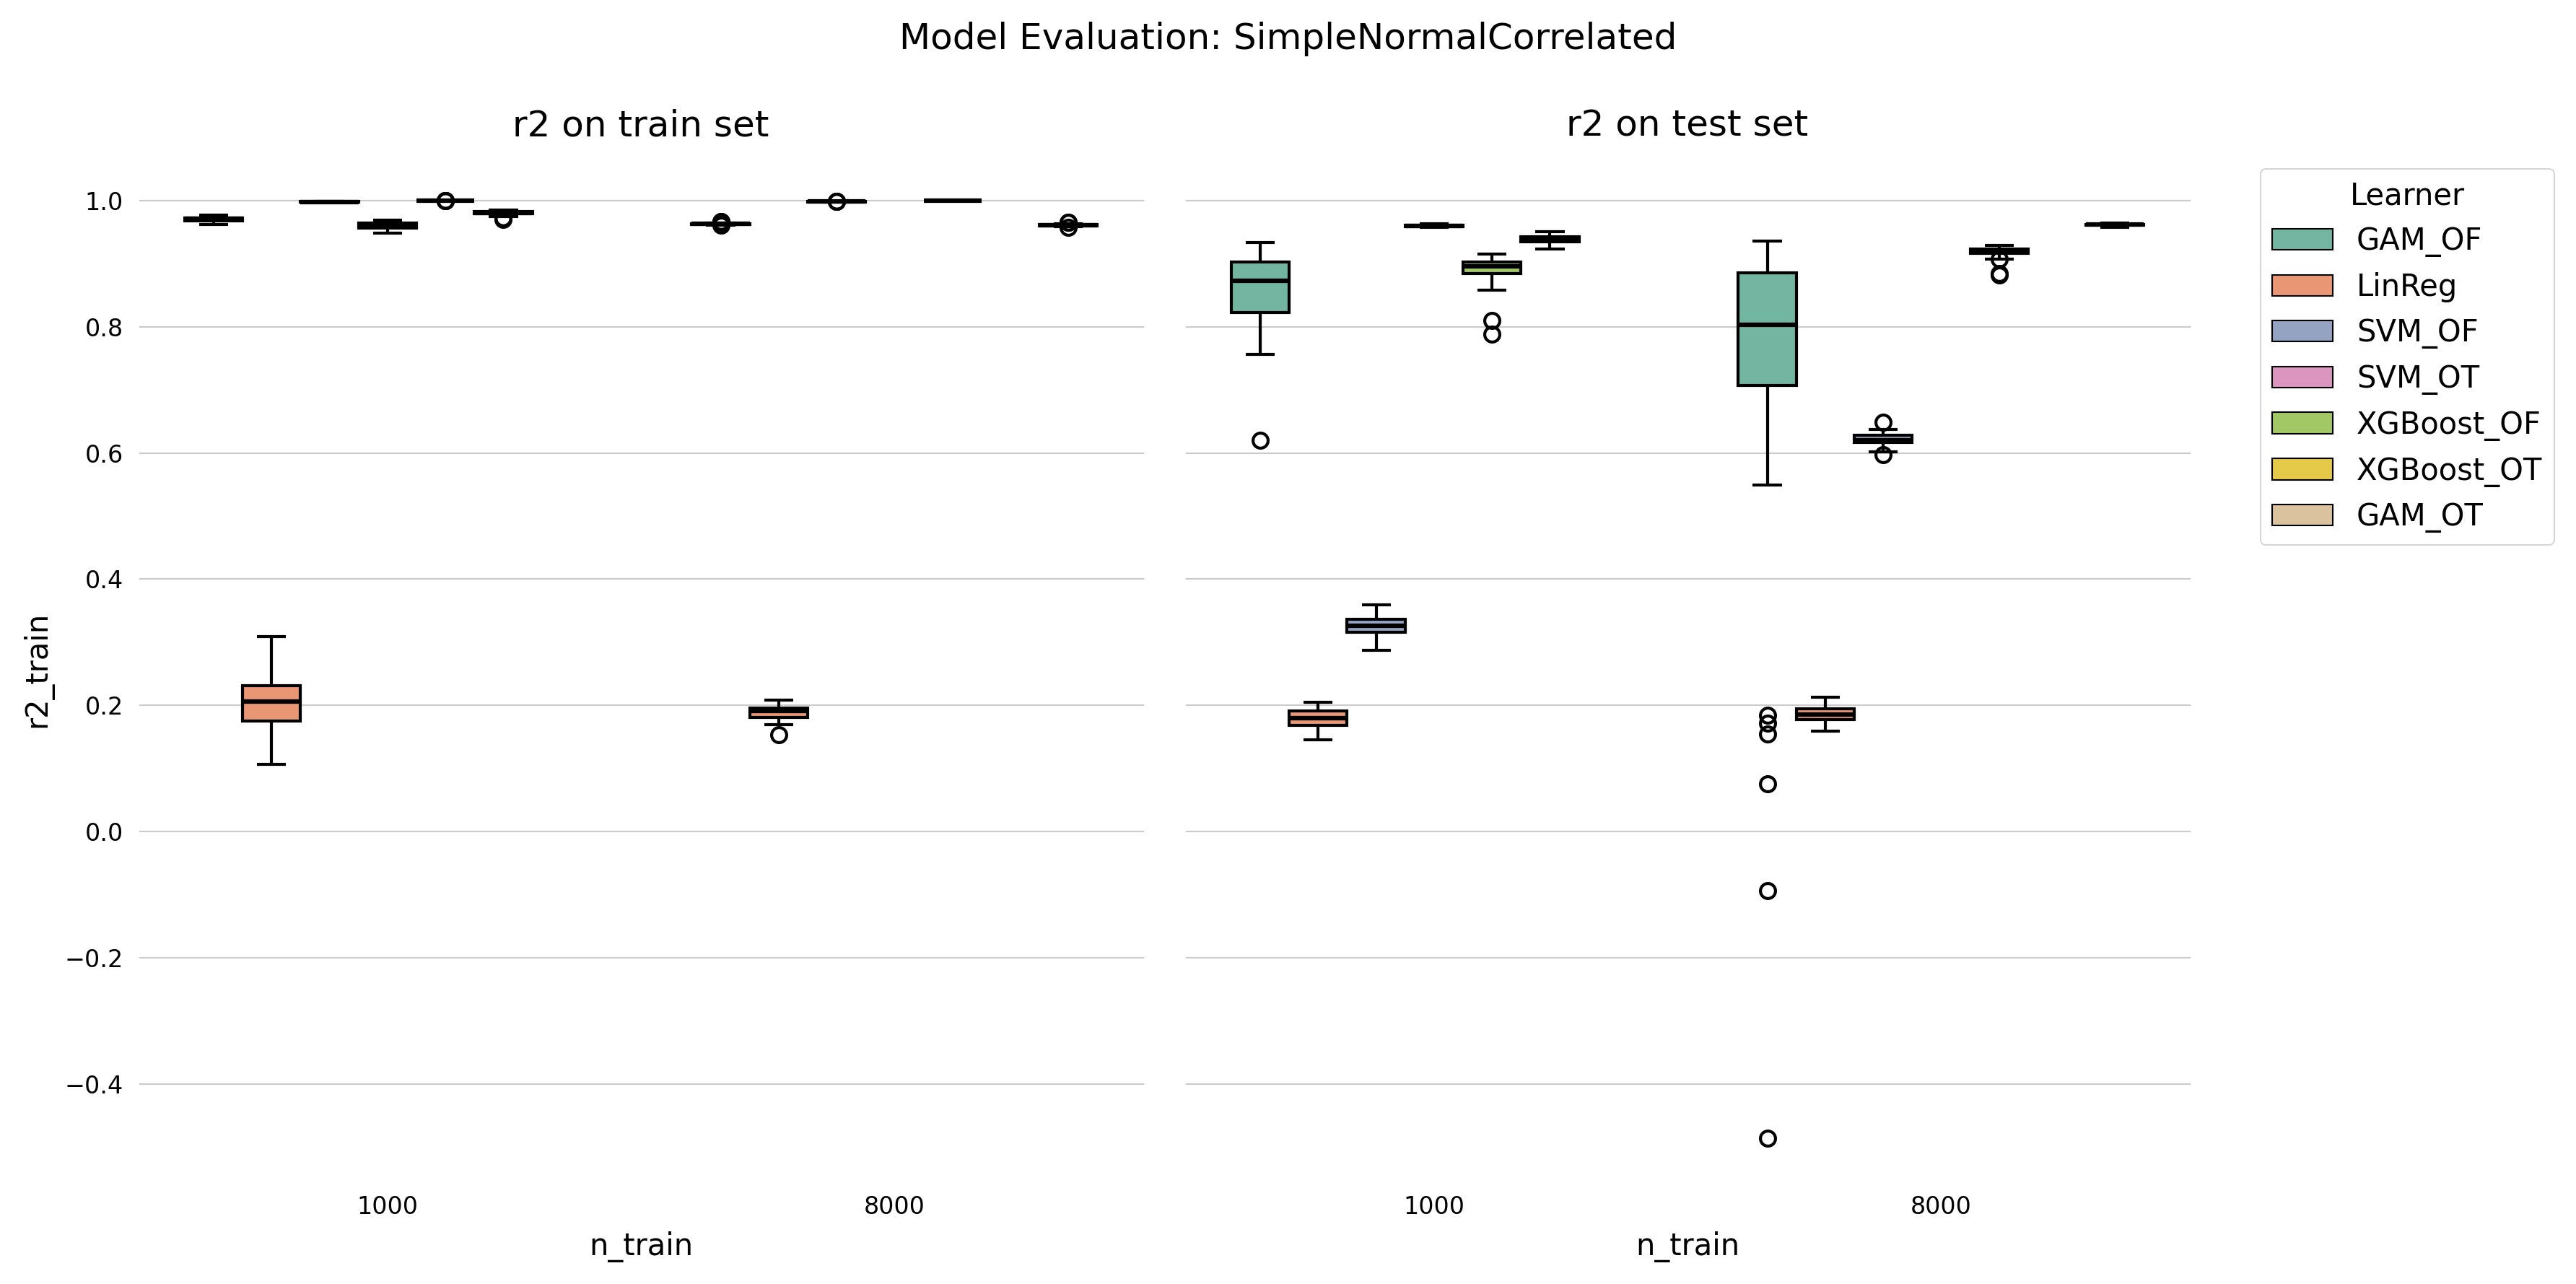

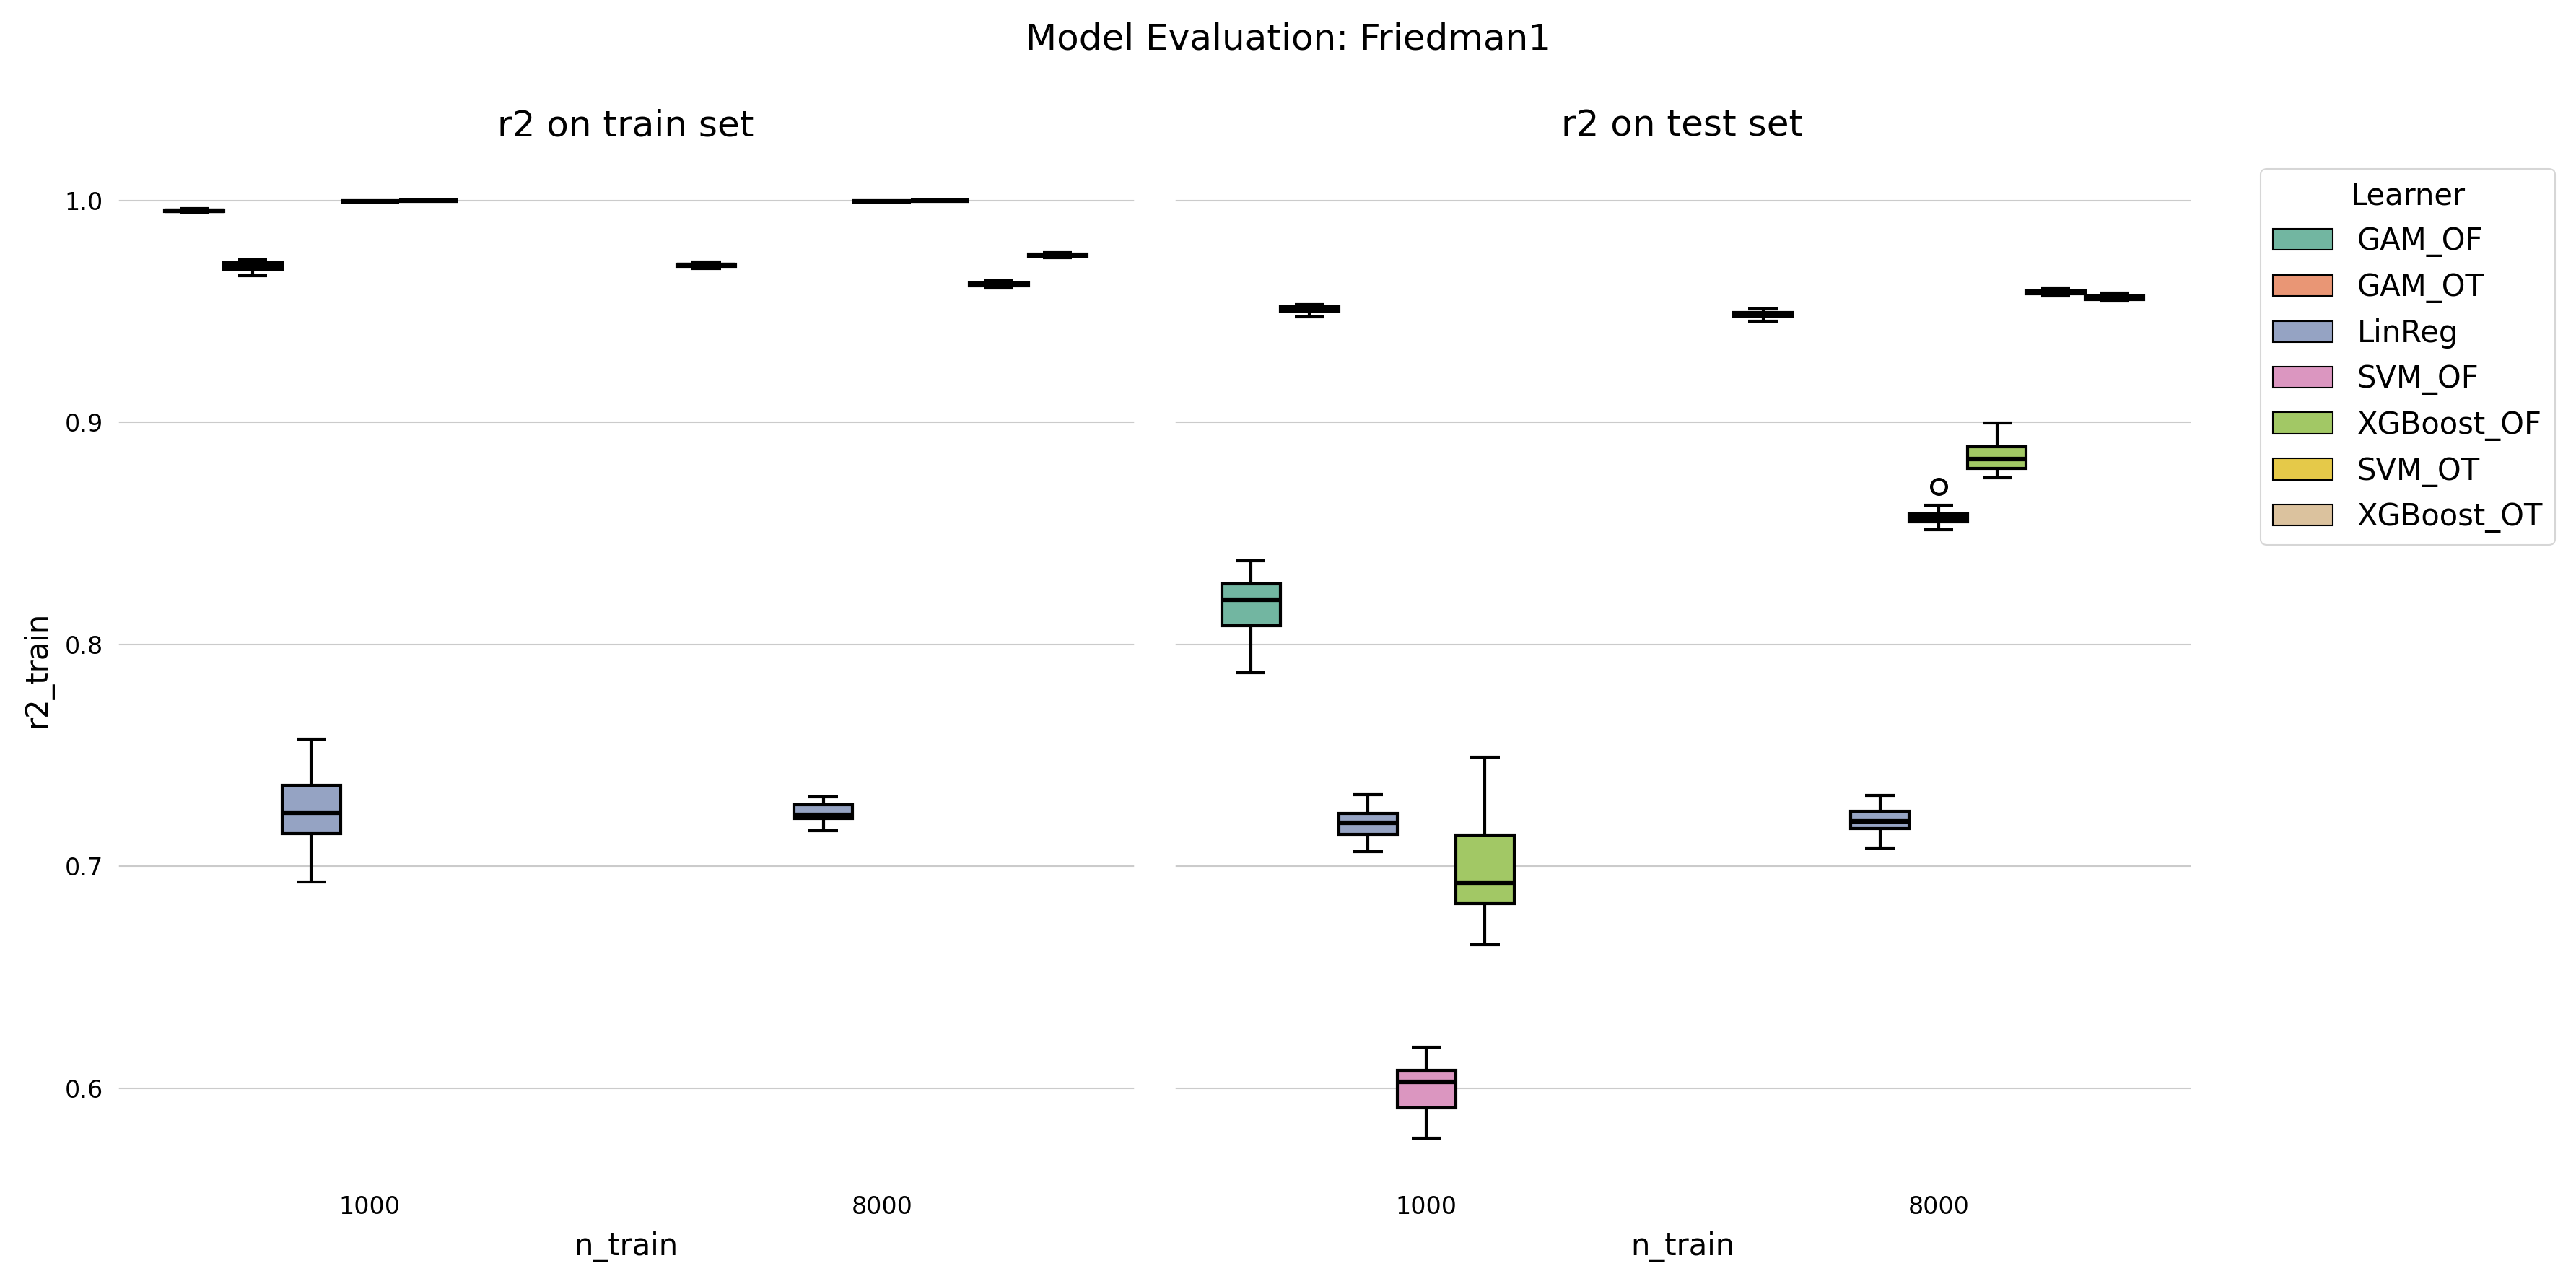

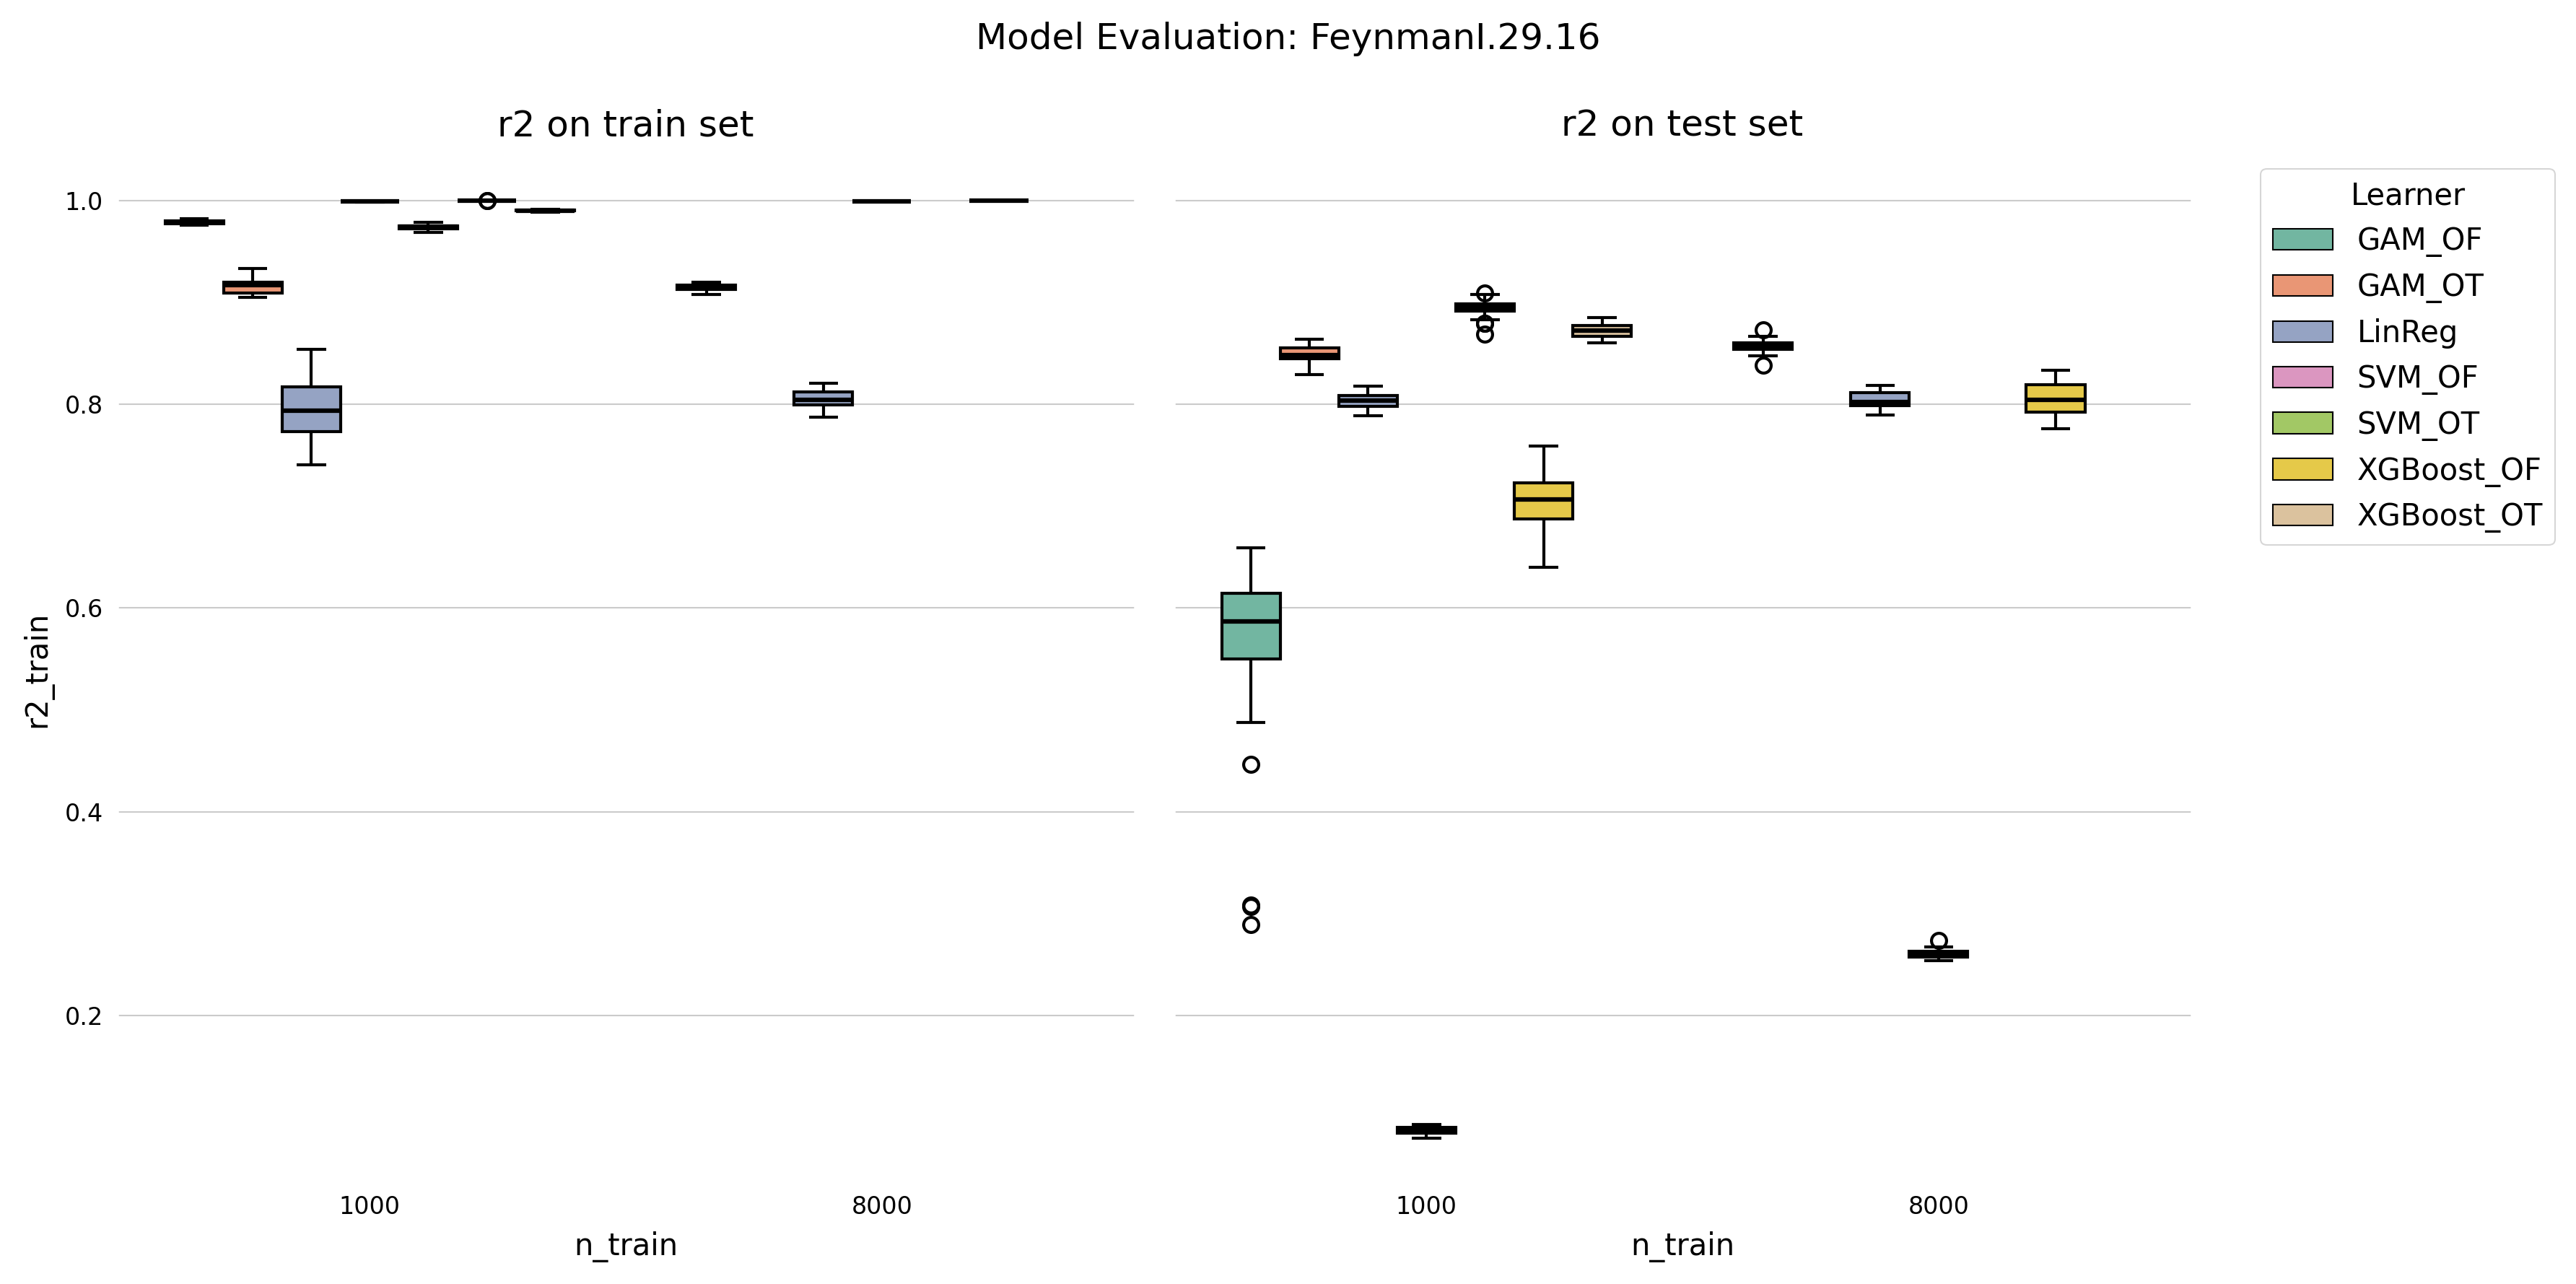

In [4]:
for df_, dataset in zip(dfs, datasets):
    boxplot_model_results(metric='r2', df=df_)
    plt.gcf().suptitle(f"Model Evaluation: {dataset}")

In [5]:
df_grouped = (
    df.groupby(["dataset", "n_train", "model"])
    .agg({"r2_train": ["mean", "std"], "r2_test": ["mean", "std"]})
    .round(4)
    .assign(
        r2_train=lambda x: x["r2_train"]["mean"].astype(str) + " ± " + x["r2_train"]["std"].astype(str),
        r2_test=lambda x: x["r2_test"]["mean"].astype(str) + " ± " + x["r2_test"]["std"].astype(str),
    )
    .droplevel(1, axis=1)
)
df_reshaped = (
    df_grouped.loc[:, ~df_grouped.columns.duplicated()]
    .reset_index()
    .pivot(columns="dataset", index=["n_train", "model"], values=["r2_train", "r2_test"])
    .reorder_levels([1, 0], axis=1)
    .reindex(
        columns=[
            ("SimpleNormalCorrelated", "r2_train"),
            ("SimpleNormalCorrelated", "r2_test"),
            ("Friedman1", "r2_train"),
            ("Friedman1", "r2_test"),
            ("FeynmanI.29.16", "r2_train"),
            ("FeynmanI.29.16", "r2_test"),
        ]
    )
)
df_reshaped

dataset            SimpleNormalCorrelated                         Friedman1  \
                                 r2_train          r2_test         r2_train   
n_train model                                                                 
1000    GAM_OF            0.9703 ± 0.0038  0.8572 ± 0.0654  0.9955 ± 0.0004   
        GAM_OT                        NaN              NaN  0.9702 ± 0.0019   
        LinReg            0.2037 ± 0.0494  0.1803 ± 0.0151  0.7249 ± 0.0162   
        SVM_OF            0.9982 ± 0.0002  0.3248 ± 0.0173     0.9996 ± 0.0   
        SVM_OT            0.9601 ± 0.0057  0.9601 ± 0.0016              NaN   
        XGBoost_OF              1.0 ± 0.0   0.888 ± 0.0277        1.0 ± 0.0   
        XGBoost_OT        0.9801 ± 0.0038  0.9375 ± 0.0064              NaN   
8000    GAM_OF            0.9631 ± 0.0014  0.6626 ± 0.3629  0.9708 ± 0.0008   
        GAM_OT            0.9612 ± 0.0017  0.9616 ± 0.0015              NaN   
        LinReg             0.1881 ± 0.012  0.1859 ± 0.0124  0.7239 ± 0.0047   
        SVM_OF            0.9982 ± 0.0001  0.6207 ± 0.0114     0.9996 ± 0.0   
        SVM_OT                        NaN              NaN   0.9623 ± 0.001   
        XGBoost_OF              1.0 ± 0.0  0.9173 ± 0.0107        1.0 ± 0.0   
        XGBoost_OT                    NaN              NaN  0.9754 ± 0.0006   

dataset                               FeynmanI.29.16                   
                            r2_test         r2_train          r2_test  
n_train model                                                          
1000    GAM_OF       0.817 ± 0.0145  0.9787 ± 0.0018  0.5571 ± 0.0978  
        GAM_OT      0.9512 ± 0.0012  0.9161 ± 0.0079  0.8494 ± 0.0083  
        LinReg      0.7196 ± 0.0065  0.7965 ± 0.0308  0.8032 ± 0.0074  
        SVM_OF      0.6006 ± 0.0113   0.999 ± 0.0001  0.0869 ± 0.0036  
        SVM_OT                  NaN  0.9739 ± 0.0026  0.8943 ± 0.0086  
        XGBoost_OF  0.6978 ± 0.0208        1.0 ± 0.0   0.7038 ± 0.025  
        XGBoost_OT              NaN  0.9903 ± 0.0007   0.8723 ± 0.007  
8000    GAM_OF      0.9485 ± 0.0013   0.9143 ± 0.003   0.8568 ± 0.007  
        GAM_OT                  NaN              NaN              NaN  
        LinReg      0.7208 ± 0.0054  0.8046 ± 0.0088  0.8041 ± 0.0082  
        SVM_OF      0.8575 ± 0.0037      0.999 ± 0.0  0.2608 ± 0.0044  
        SVM_OT      0.9588 ± 0.0009              NaN              NaN  
        XGBoost_OF  0.8843 ± 0.0064        1.0 ± 0.0  0.8055 ± 0.0153  
        XGBoost_OT  0.9562 ± 0.0009              NaN              NaN